## Run Ad-Hoc Data Bias Analysis

### Run Bias Analysis In The Notebook using smclarify

In [4]:
!pip install -q smclarify==0.1

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
awscli 1.22.23 requires botocore==1.23.23, but you have botocore 1.23.24 which is incompatible.
awscli 1.22.23 requires PyYAML<5.5,>=3.10, but you have pyyaml 6.0 which is incompatible.
awscli 1.22.23 requires rsa<4.8,>=3.1.2, but you have rsa 4.8 which is incompatible.
You should consider upgrading via the '/opt/conda/bin/python -m pip install --upgrade pip' command.


In [5]:
from smclarify.bias import report
from typing import Dict
from collections import defaultdict
import pandas as pd
import seaborn as sns

## Read Dataset From S3

In [6]:
%store -r bias_data_s3_uri
print(bias_data_s3_uri)

s3://sagemaker-us-east-1-222711858116/bias-detection-1650148594/integrated_data.csv


In [7]:
%store -r balanced_bias_data_s3_uri
print(balanced_bias_data_s3_uri)

s3://sagemaker-us-east-1-222711858116/bias-detection-1650148594/integrated_data_balanced.csv


In [8]:
!aws s3 cp $bias_data_s3_uri ./data-clarify/

download: s3://sagemaker-us-east-1-222711858116/bias-detection-1650148594/integrated_data.csv to data-clarify/integrated_data.csv


In [9]:
!aws s3 cp $balanced_bias_data_s3_uri ./data-clarify/

download: s3://sagemaker-us-east-1-222711858116/bias-detection-1650148594/integrated_data_balanced.csv to data-clarify/integrated_data_balanced.csv


## Analyze Unbalanced Data


In [10]:
df = pd.read_csv("./data-clarify/integrated_data.csv")
df.shape

(1384617, 11)

<AxesSubplot:xlabel='reordered', ylabel='count'>

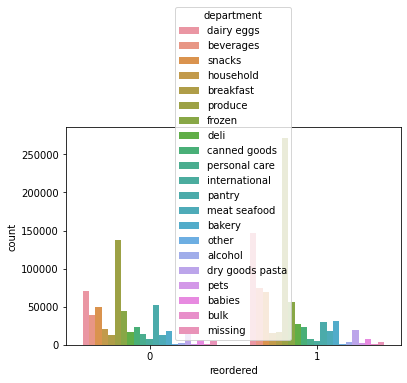

In [11]:
sns.countplot(data=df, x="reordered", hue="department")

## Calculate Bias Metrics on Unbalanced Data



### Define

     Facet Column (= department),
     Label Column (= reordered),
     Positive Label Value (= 1)




In [12]:
facet_column = report.FacetColumn(name="department")

label_column = report.LabelColumn(
    name="reordered", 
    data=df["reordered"], 
    positive_label_values=[1]
)

### Run SageMaker Clarify Bias Report

In [13]:
report.bias_report(
    df=df, 
    facet_column=facet_column, 
    label_column=label_column, 
    stage_type=report.StageType.PRE_TRAINING, 
    metrics=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"]
)

/opt/conda/lib/python3.7/site-packages/smclarify/bias/report.py:381: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(facet_column.name, 1)
/opt/conda/lib/python3.7/site-packages/smclarify/bias/report.py:387: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(label_column.name, 1)


[{'value_or_threshold': 'dairy eggs',
  'metrics': [{'name': 'CI',
    'description': 'Class Imbalance (CI)',
    'value': 0.6864822546595918},
   {'name': 'DPL',
    'description': 'Difference in Positive Proportions in Labels (DPL)',
    'value': -0.0905688494355229},
   {'name': 'JS',
    'description': 'Jensen-Shannon Divergence (JS)',
    'value': 0.006435206386496661},
   {'name': 'KL',
    'description': 'Kullback-Liebler Divergence (KL)',
    'value': 0.017954482978937494},
   {'name': 'KS',
    'description': 'Kolmogorov-Smirnov Distance (KS)',
    'value': 0.0905688494355229},
   {'name': 'LP', 'description': 'L-p Norm (LP)', 'value': 0.1280836952002433},
   {'name': 'TVD',
    'description': 'Total Variation Distance (TVD)',
    'value': 0.09056884943552287}]},
 {'value_or_threshold': 'beverages',
  'metrics': [{'name': 'CI',
    'description': 'Class Imbalance (CI)',
    'value': 0.8352670810772943},
   {'name': 'DPL',
    'description': 'Difference in Positive Proportions 

## Balance the data

In [14]:
df_grouped_by = df.groupby(["department", "reordered"])[["department", "reordered"]]
df_balanced = df_grouped_by.apply(lambda x: x.sample(df_grouped_by.size().min()).reset_index(drop=True))
df_balanced.shape

(24066, 2)

<AxesSubplot:xlabel='reordered', ylabel='count'>

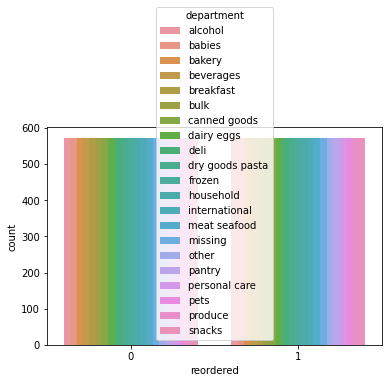

In [15]:
import seaborn as sns

sns.countplot(data=df_balanced, x="reordered", hue="department")

## Calculate Bias Metrics on Balanced Data
### Define

    Facet Column (= department),
    Label Column (= reordered),
    Positive Label Value (= 1)




## Run SageMaker Clarify Bias Report

In [16]:
report.bias_report(
    df=df_balanced, 
    facet_column=facet_column, 
    label_column=label_column, 
    stage_type=report.StageType.PRE_TRAINING, 
    metrics=["CI", "DPL", "KL", "JS", "LP", "TVD", "KS"]
)

/opt/conda/lib/python3.7/site-packages/smclarify/bias/report.py:381: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(facet_column.name, 1)
/opt/conda/lib/python3.7/site-packages/smclarify/bias/report.py:387: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(label_column.name, 1)
DPL metrics failed
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/smclarify/bias/report.py", line 294, in _categorical_metric_call_wrapper
    group_variable=group_variable,
  File "/opt/conda/lib/python3.7/site-packages/smclarify/bias/metrics/__init__.py", line 26, in call_metric
    return metric(**{key: kwargs[key] for key in inspect.signature(metric).parameters.keys()})
  File "/opt/conda/lib/python3.7/site-packages/smclarify/bias/metrics/pretraining.py", line 71, in DPL
    return 

[{'value_or_threshold': 'alcohol',
  'metrics': [{'name': 'CI',
    'description': 'Class Imbalance (CI)',
    'value': 0.9047619047619048},
   {'name': 'DPL',
    'description': 'Difference in Positive Proportions in Labels (DPL)',
    'value': None,
    'error': 'cannot join with no overlapping index names'},
   {'name': 'JS',
    'description': 'Jensen-Shannon Divergence (JS)',
    'value': None,
    'error': "Buffer dtype mismatch, expected 'Python object' but got 'long'"},
   {'name': 'KL',
    'description': 'Kullback-Liebler Divergence (KL)',
    'value': None,
    'error': "Buffer dtype mismatch, expected 'Python object' but got 'long'"},
   {'name': 'KS',
    'description': 'Kolmogorov-Smirnov Distance (KS)',
    'value': None,
    'error': "Buffer dtype mismatch, expected 'Python object' but got 'long'"},
   {'name': 'LP',
    'description': 'L-p Norm (LP)',
    'value': None,
    'error': "Buffer dtype mismatch, expected 'Python object' but got 'long'"},
   {'name': 'TVD',
 